In [1]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import itertools
import pandas as pd
import h5py 
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import os.path
import argparse
import h5py 
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [2]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.01, 0.1, 1, 10,100]
    gammas = [0.001, 0.01, 0.1, 1,1e-1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [3]:
def rbf_kernel(X,Y):
    K=np.zeros((X.shape[0],Y.shape[0]))
    for x1,x2 in enumerate(X):
        for x3,x4 in enumerate(Y):
            K[x1,x3]= np.exp(-0.7*np.linalg.norm(x2-x4)**2)
    return K

In [4]:
def data_division(X,Y):
    train, test,train_label, test_label = train_test_split(X, Y, test_size=0.2, random_state=33)
    return train,train_label,test,test_label        

In [9]:
def onevsone(X,Y,labels,train_X,train_Y,test_X,test_Y,flag):
        param=svc_param_selection(X, Y,5)
        n_class=len(np.unique(Y))
        print(param)
        crrct,wrng=0,0
        ans_arr=np.zeros((len(test_X),labels))
        label1=0
        while label1<labels:
            label2=label1+1
            while label2<labels:
                trainXNew=[]
                trainYNew=[]
                for j in range(len(train_Y)):
                    if(train_Y[j]==label1):
                        trainXNew.append(train_X[j])
                        trainYNew.append(1)
                    elif (train_Y[j]==label2):
                        trainXNew.append(train_X[j])
                        trainYNew.append(0)
                model=svm.SVC(kernel=rbf_kernel,C=1)                                                     
                model.fit(trainXNew,trainYNew)
                ker=model.kernel
                spprt_vec=train_X[model.support_]
                dual_coef=model.dual_coef_
                intercpt=model.intercept_
                predicted=np.dot(dual_coef,ker(spprt_vec,test_X))+intercpt
                predicted=predicted[0]
                for j in range (0,len(test_X)):
                    if(predicted[j]>0):
                        ans_arr[j][label1]+=1
                    else:
                        ans_arr[j][label2]+=1
                label2=label2+1
            label1=label1+1 
        predicted_arr=[]
        for index in range(0,len(ans_arr)):
            n=np.argmax(ans_arr[index])
            predicted_arr.append(n)
        actu=pd.Series(test_Y,name='Correct')
        pred=pd.Series(predicted_arr,name='Predicted')
        confusion_mat= pd.crosstab(actu,pred,rownames=['Correct'],colnames=['Predicted'])
        print(confusion_mat)
        plt.imshow(confusion_mat,interpolation='nearest', cmap=plt.cm.Blues)
        tick_marks = np.arange(len(confusion_mat.columns))
        plt.xticks(tick_marks, confusion_mat.columns, rotation=45)
        plt.yticks(tick_marks, confusion_mat.index)
        for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
                plt.text(j,i,confusion_mat[i][j],horizontalalignment="center",color="black")

        plt.ylabel(confusion_mat.index.name)
        plt.xlabel(confusion_mat.columns.name)
        plt.tight_layout()
        plt.figure()
        plt.show()
        if(flag!=1):
            fpr,tpr,th = roc_curve(test_Y,predicted_arr)
            roc_auc = auc(fpr,tpr)
            plt.figure()
            lw = 2
            plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc="lower right")
            plt.show()
        else:
            y_score = test_Y
            y_binary = label_binarize(predicted_arr, classes=[0, 1, 2]) 
            fpr = dict() 
            tpr = dict() 
            roc_auc = dict() 
            lw=2 
            for i in range(n_class): 
                fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_score) 
                print(fpr[i])
                roc_auc[i] = auc(fpr[i], tpr[i]) 
                fpr["micro"], tpr["micro"], _ = roc_curve(y_binary[:,i].ravel(), y_score.ravel()) 
                roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)])) 
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_class): 
                mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
            mean_tpr /= n_class
            fpr["macro"] = all_fpr 
            tpr["macro"] = mean_tpr 
            roc_auc["macro"] = auc(fpr["macro"], tpr["macro"]) 
            plt.figure() 
            plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4) 
            plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4) 
            colors = cycle(['aqua', 'darkorange', 'cornflowerblue']) 
            for i,color in zip(range(n_class), colors): 
                plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i])) 
            plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
            plt.xlim([0.0, 1.0]) 
            plt.ylim([0.0, 1.05]) 
            plt.xlabel('False Positive Rate') 
            plt.ylabel('True Positive Rate') 
            plt.legend(loc="lower right")
        plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
        ax=None
        if ax is None:
            ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x_dim = np.linspace(xlim[0], xlim[1], 30)
        y_dim= np.linspace(ylim[0], ylim[1], 30)
        Y_axis, X_axis = np.meshgrid(y_dim, x_dim)
        xy = np.vstack([X_axis.ravel(), Y_axis.ravel()]).T
        P = model.decision_function(xy).reshape(X_axis.shape)
        ax.contour(X_axis, Y_axis, P, colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
        ax.scatter(spprt_vec[:, 0],spprt_vec[:, 1],s=300, linewidth=1, facecolors='none');
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plt.show()
        a = accuracy_score(test_Y,predicted_arr)
        print('Accuracy',a)
        print('F1-Score',f1_score(test_Y,predicted_arr, average='macro') )                   


for DataSet 1
{'C': 0.01, 'gamma': 1}
Predicted   0  1
Correct         
0          12  0
1           0  8


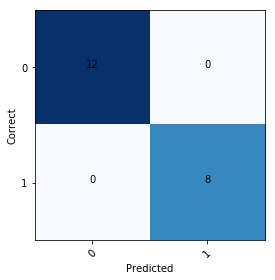

<Figure size 432x288 with 0 Axes>

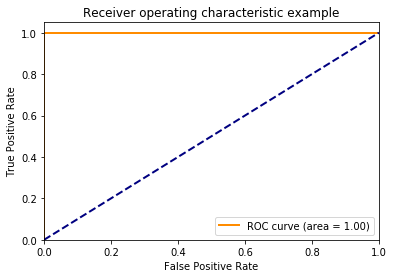

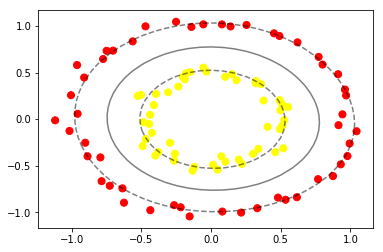

Accuracy 1.0
F1-Score 1.0

for DataSet 2
{'C': 1, 'gamma': 1}
Predicted   0  1
Correct         
0          10  0
1           1  9


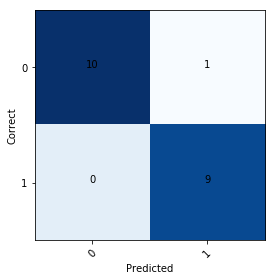

<Figure size 432x288 with 0 Axes>

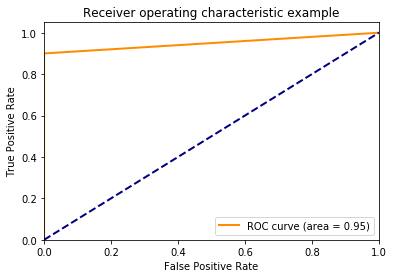

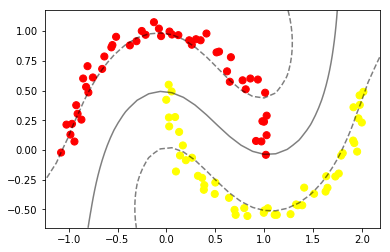

Accuracy 0.95
F1-Score 0.949874686716792

for DataSet 3


/Users/nikitamehrotra/Downloads/assignment1/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.1, 'gamma': 0.01}
Predicted  0  1  2
Correct           
0          1  2  0
1          4  3  4
2          5  0  1


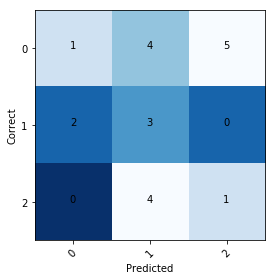

<Figure size 432x288 with 0 Axes>

[0.  0.1 0.8 1. ]
[0.         0.4        0.93333333 1.        ]
[0.         0.33333333 0.8        1.        ]


/Users/nikitamehrotra/Downloads/assignment1/env/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


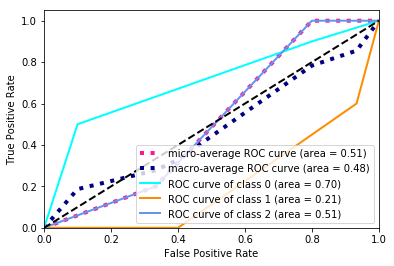

Accuracy 0.25
F1-Score 0.23688811188811185

for DataSet 4
{'C': 100, 'gamma': 1}
Predicted    0    1
Correct            
0          178   20
1           22  180


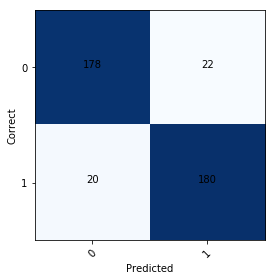

<Figure size 432x288 with 0 Axes>

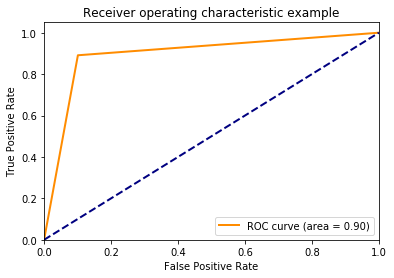

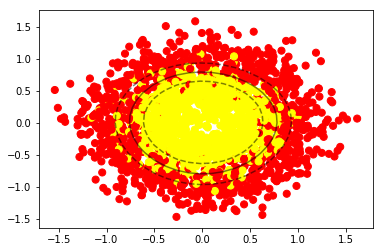

Accuracy 0.895
F1-Score 0.8949973749343734


In [11]:
for i in range(0,4):
    j=i+1;
    flag=0
    print('\nfor DataSet',j)
    filename="data_"+str(j)+".h5"
    file=h5py.File(filename,'r');
    X=file.get('x')
    Y=file.get('y')
    X=np.array(X)
    Y=np.array(Y)
    labels=np.max(Y)+1
    train_X,train_Y,test_X,test_Y =data_division(X,Y)
    if(j!=3):
        onevsone(X,Y,labels,train_X,train_Y,test_X,test_Y,flag)
    else:
        flag=1
        onevsone(X,Y,labels,train_X,train_Y,test_X,test_Y,flag)